In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns; sns.set(style="ticks", color_codes=True)
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.feature_selection import RFE
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from glob import glob
from sklearn.model_selection import train_test_split
from google.colab import drive
import os

drive.mount('/content/drive')

!ls "/content/drive/My Drive/Walmart"

os.chdir("/content/drive/My Drive/Walmart")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
 features.csv					     stores.csv   train.csv
'Sales Forecasting Random Forest Regression.ipynb'   test.csv


In [0]:
features = pd.read_csv('features.csv')
dataset = pd.read_csv('train.csv')
stores = pd.read_csv('stores.csv')
test = pd.read_csv('test.csv')

In [0]:
dataset = dataset.merge(stores, how='left').merge(features, how='left')

In [5]:
dataset

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,1,2010-02-05,24924.50,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
1,1,1,2010-02-12,46039.49,True,A,151315,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106
2,1,1,2010-02-19,41595.55,False,A,151315,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106
3,1,1,2010-02-26,19403.54,False,A,151315,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106
4,1,1,2010-03-05,21827.90,False,A,151315,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,45,98,2012-09-28,508.37,False,B,118221,64.88,3.997,4556.61,20.64,1.50,1601.01,3288.25,192.013558,8.684
421566,45,98,2012-10-05,628.10,False,B,118221,64.89,3.985,5046.74,NaN,18.82,2253.43,2340.01,192.170412,8.667
421567,45,98,2012-10-12,1061.02,False,B,118221,54.47,4.000,1956.28,NaN,7.89,599.32,3990.54,192.327265,8.667
421568,45,98,2012-10-19,760.01,False,B,118221,56.47,3.969,2004.02,NaN,3.18,437.73,1537.49,192.330854,8.667


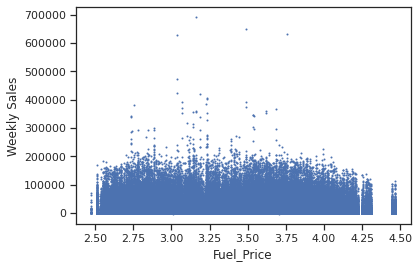

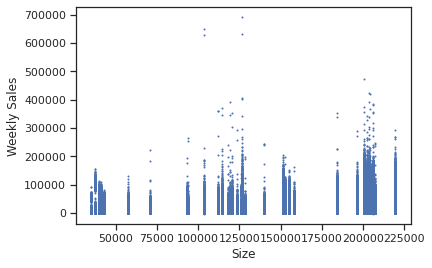

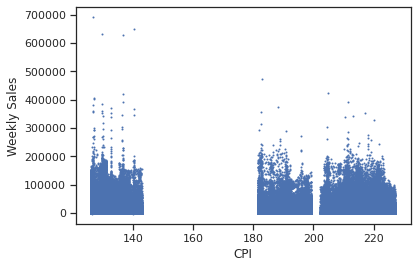

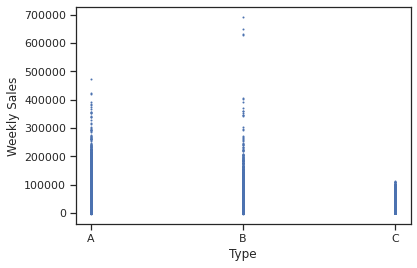

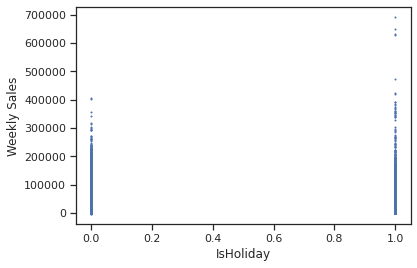

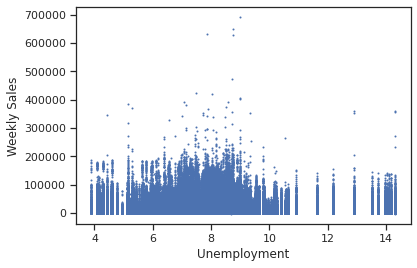

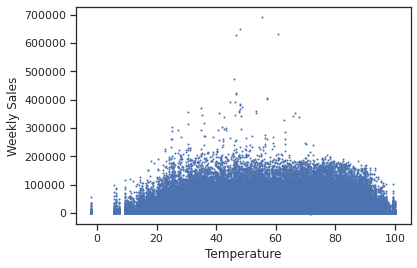

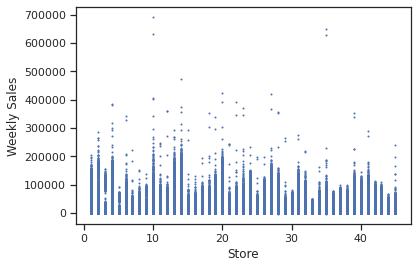

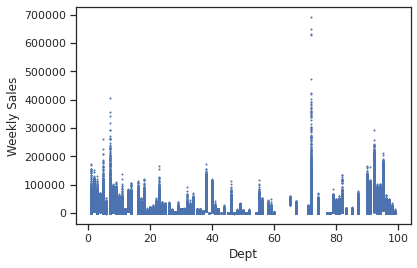

In [6]:
# Data Visualization
def scatter(dataset, column):
    plt.figure()
    plt.scatter(dataset[column] , dataset['Weekly_Sales'], s = 1)
    plt.ylabel('Weekly Sales')
    plt.xlabel(column)
    
scatter(dataset, 'Fuel_Price')
scatter(dataset, 'Size')
scatter(dataset, 'CPI')
scatter(dataset, 'Type')
scatter(dataset, 'IsHoliday')
scatter(dataset, 'Unemployment')
scatter(dataset, 'Temperature')
scatter(dataset, 'Store')
scatter(dataset, 'Dept')

In [0]:
# Data Cleaning (Fill NaN with 0)
dataset = pd.get_dummies(dataset, columns=["Type"])
dataset[['MarkDown1','MarkDown2','MarkDown3','MarkDown4', 'MarkDown5']] = dataset[['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']].fillna(0)
dataset['Month'] = pd.to_datetime(dataset['Date']).dt.month
dataset = dataset.drop(columns=["Date", "CPI", "Fuel_Price", 'Unemployment', 'MarkDown3'])

In [8]:
dataset

,Store,Dept,Weekly_Sales,IsHoliday,Size,Temperature,MarkDown1,MarkDown2,MarkDown4,MarkDown5,Type_A,Type_B,Type_C,Month
0,1,1,24924.50,False,151315,42.31,0.00,0.00,0.00,0.00,1,0,0,2
1,1,1,46039.49,True,151315,38.51,0.00,0.00,0.00,0.00,1,0,0,2
2,1,1,41595.55,False,151315,39.93,0.00,0.00,0.00,0.00,1,0,0,2
3,1,1,19403.54,False,151315,46.63,0.00,0.00,0.00,0.00,1,0,0,2
4,1,1,21827.90,False,151315,46.50,0.00,0.00,0.00,0.00,1,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,45,98,508.37,False,118221,64.88,4556.61,20.64,1601.01,3288.25,0,1,0,9
421566,45,98,628.10,False,118221,64.89,5046.74,0.00,2253.43,2340.01,0,1,0,10
421567,45,98,1061.02,False,118221,54.47,1956.28,0.00,599.32,3990.54,0,1,0,10
421568,45,98,760.01,False,118221,56.47,2004.02,0.00,437.73,1537.49,0,1,0,10


In [0]:
dataset['IsHoliday'] = dataset['IsHoliday'].astype(float)

In [10]:
dataset

,Store,Dept,Weekly_Sales,IsHoliday,Size,Temperature,MarkDown1,MarkDown2,MarkDown4,MarkDown5,Type_A,Type_B,Type_C,Month
0,1,1,24924.50,0.0,151315,42.31,0.00,0.00,0.00,0.00,1,0,0,2
1,1,1,46039.49,1.0,151315,38.51,0.00,0.00,0.00,0.00,1,0,0,2
2,1,1,41595.55,0.0,151315,39.93,0.00,0.00,0.00,0.00,1,0,0,2
3,1,1,19403.54,0.0,151315,46.63,0.00,0.00,0.00,0.00,1,0,0,2
4,1,1,21827.90,0.0,151315,46.50,0.00,0.00,0.00,0.00,1,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,45,98,508.37,0.0,118221,64.88,4556.61,20.64,1601.01,3288.25,0,1,0,9
421566,45,98,628.10,0.0,118221,64.89,5046.74,0.00,2253.43,2340.01,0,1,0,10
421567,45,98,1061.02,0.0,118221,54.47,1956.28,0.00,599.32,3990.54,0,1,0,10
421568,45,98,760.01,0.0,118221,56.47,2004.02,0.00,437.73,1537.49,0,1,0,10


In [0]:
# Split testing and training
X = dataset.drop(columns=['Weekly_Sales'])
y = dataset['Weekly_Sales']

In [12]:
X

,Store,Dept,IsHoliday,Size,Temperature,MarkDown1,MarkDown2,MarkDown4,MarkDown5,Type_A,Type_B,Type_C,Month
0,1,1,0.0,151315,42.31,0.00,0.00,0.00,0.00,1,0,0,2
1,1,1,1.0,151315,38.51,0.00,0.00,0.00,0.00,1,0,0,2
2,1,1,0.0,151315,39.93,0.00,0.00,0.00,0.00,1,0,0,2
3,1,1,0.0,151315,46.63,0.00,0.00,0.00,0.00,1,0,0,2
4,1,1,0.0,151315,46.50,0.00,0.00,0.00,0.00,1,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,45,98,0.0,118221,64.88,4556.61,20.64,1601.01,3288.25,0,1,0,9
421566,45,98,0.0,118221,64.89,5046.74,0.00,2253.43,2340.01,0,1,0,10
421567,45,98,0.0,118221,54.47,1956.28,0.00,599.32,3990.54,0,1,0,10
421568,45,98,0.0,118221,56.47,2004.02,0.00,437.73,1537.49,0,1,0,10


In [13]:
y

0         24924.50
1         46039.49
2         41595.55
3         19403.54
4         21827.90
            ...   
421565      508.37
421566      628.10
421567     1061.02
421568      760.01
421569     1076.80
Name: Weekly_Sales, Length: 421570, dtype: float64

In [0]:
# Split training and testing
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 0)

In [15]:
X_train.shape

(379413, 13)

In [16]:
X_test.shape

(42157, 13)

In [17]:
y_train.shape # .reshape(-1,1)

(379413,)

In [18]:
y_test.shape # .reshape(-1,1)

(42157,)

In [19]:
# Train the model
clf = RandomForestRegressor(n_estimators=100, max_features='log2', verbose=1)
clf.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.2min finished


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='log2', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=1, warm_start=False)

In [20]:
predicted = clf.predict(X_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    3.0s finished


In [21]:
predicted.reshape(-1,1)

array([[10544.1546],
       [28739.803 ],
       [ 1582.5331],
       ...,
       [10421.2391],
       [ 3070.649 ],
       [41081.4924]])

In [0]:
compare = np.concatenate((predicted.reshape(len(predicted), 1), y_test.values.reshape(len(y_test), 1)), 1)

In [23]:
compare

array([[10544.1546,  9526.04  ],
       [28739.803 , 26393.68  ],
       [ 1582.5331,   736.16  ],
       ...,
       [10421.2391,   109.    ],
       [ 3070.649 ,  6852.46  ],
       [41081.4924, 34155.59  ]])

In [24]:
def calculate_error(test_y, predicted, weights):
    return mean_absolute_error(test_y, predicted, sample_weight=weights)

weights = X_test['IsHoliday'].replace(True, 5).replace(False, 1)
error = calculate_error(y_test, predicted, weights)

print("error = ", error)

error =  8638.817636140757


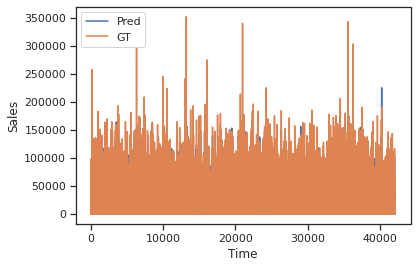

In [25]:
plt.plot(range(len(predicted)), predicted, label = 'Pred')
plt.plot(range(len(y_test)), y_test, label = 'GT')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.legend()
plt.show()

In [0]:
# Adding Random Search CV
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [24]:
# Train the model
clf = RandomForestRegressor()
clf_random = RandomizedSearchCV(estimator = clf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
clf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


KeyboardInterrupt: ignored

In [0]:
best_acc = clf_random.best_score_
best_param = clf_random.best_params_
print("best_acc = ", best_acc)
print("best_param = ", best_param)

In [0]:
# Adding Grid Search CV 1
from sklearn.model_selection import GridSearchCV

# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

In [0]:
# Adding Grid Search CV 2
from sklearn.model_selection import GridSearchCV

# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [90, 100],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 5],
    'min_samples_split': [8, 12],
    'n_estimators': [300, 1000]
}

In [28]:
# Train the model
clf = RandomForestRegressor()
grid_search = GridSearchCV(estimator = clf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 32 candidates, totalling 96 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 97.1min
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed: 268.8min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [30]:
best_acc = grid_search.best_score_
best_param = grid_search.best_params_
print("best_acc = ", best_acc)
print("best_param = ", best_param)

best_acc =  0.798790596535739
best_param =  {'bootstrap': True, 'max_depth': 90, 'max_features': 3, 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 1000}


In [26]:
clf = RandomForestRegressor(n_estimators = 1000,  verbose=1, bootstrap = True, max_depth = 90, max_features = 3, min_samples_leaf = 3, min_samples_split=8)
clf.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:  8.4min finished


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=90, max_features=3, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=3,
                      min_samples_split=8, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=None, oob_score=False,
                      random_state=None, verbose=1, warm_start=False)

In [27]:
predicted = clf.predict(X_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:   16.4s finished


In [28]:
predicted.reshape(-1,1)

array([[11072.38166143],
       [29334.66835649],
       [ 2409.61429853],
       ...,
       [ 5738.02105932],
       [ 4996.76189617],
       [39106.08992345]])

In [0]:
compare = np.concatenate((predicted.reshape(len(predicted), 1), y_test.values.reshape(len(y_test), 1)), 1)

In [30]:
compare

array([[11072.38166143,  9526.04      ],
       [29334.66835649, 26393.68      ],
       [ 2409.61429853,   736.16      ],
       ...,
       [ 5738.02105932,   109.        ],
       [ 4996.76189617,  6852.46      ],
       [39106.08992345, 34155.59      ]])

In [31]:
def calculate_error(test_y, predicted, weights):
    return mean_absolute_error(test_y, predicted, sample_weight=weights)

weights = X_test['IsHoliday'].replace(True, 5).replace(False, 1)
error = calculate_error(y_test, predicted, weights)

print("error = ", error)

error =  8373.477692955079


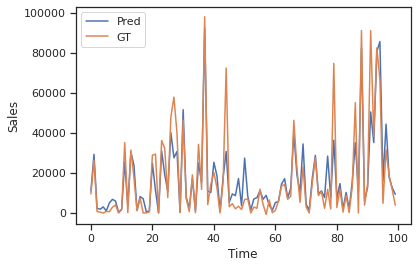

In [42]:
pred = predicted[:100]
gt = y_test[:100]
plt.plot(range(len(pred)), pred, label = 'Pred')
plt.plot(range(len(gt)), gt, label = 'GT')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.legend()
plt.show()

In [39]:
def calculate_error(test_y, predicted):
    return mean_absolute_error(test_y, predicted)

error = calculate_error(y_test, predicted)

print("error = ", error)

error =  5479.674113159795


In [40]:
from sklearn.metrics import r2_score

r2 = r2_score(y_test, predicted)

print("r2 = ", r2)

r2 =  0.817443813914929
